<a href="https://colab.research.google.com/github/musman2012/ml-data_science/blob/master/SOH_Prediction/Phase_II_ML_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Phase-II
This phase would have the following keys steps to perform:
* Apply labelling/binning on the data (yet to decided the technique)
* Make three clusters/subsets of the data on the basis of cycle variable
* Apply Association Rule Mining on the subsets
* Apply prediction technique to classify the target variable soh
* Evaluate Models Results

More explanation for the process and what I want to acheive 

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import platform
import dill
dill.load_session('phase-II-ml-copy.db')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
'''
authored by Muhammad Usman (musman14@student.bradford.ac.uk)

!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

FILE_PATH = "batteries_processed.csv"
bat_data = pd.read_csv(FILE_PATH, error_bad_lines = False)    # reading the data from csv file

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Removing the same features which were removed in Phase-I as well

In [0]:
filtered_data = bat_data.copy()
columns_to_drop = ['id', 'vin', 'vin_prefix', 'record_id','recorded_time', 'actual_time', 'arrival_time', 'powermode', 'mheader_vin', 'mheader_time', 'mheader_type', 'message','cat4', 'cat6', 'cat7', 'inlet_coolant_temp','cooling_energy_used', 'max_soh_cell', 'fuse_temp', 'power_soh', 'min_soh', 'max_soh', 'min_soh_cell_id','imbalance_percent', 'parkingdata_hvbattavgsocoatevent', 'parkingdata_hvbattavtempatevent']
filtered_data = filtered_data.drop(columns=columns_to_drop)
filtered_data.head()

,odometer,ambient_temp,vehicle_speed,balancing_trigger_cell,balancing_status,min_voltage,min_temp,traction_current,max_voltage,imbalance,traction_voltage,min_temp_cell,min_voltage_cell,max_voltage_cell,max_temp,max_temp_cell,emodule_temp,thermal_manager_mode,outlet_coolant_temp,soh,fast_charge_count,cycle,num_cycle,fast_charge,trip_distance
0,10619,6.5,0.0,22,noBalancing,4.107,12,0.675,4.153,0.046,445,15,22,96,14,1,135,activeHeating,195,98.0,0,storage,1,False,0
1,9531,4.0,0.0,22,noBalancing,3.983,6,7.375,4.008,0.025,432,16,36,21,7,1,90,idle,55,98.0,0,storage,1,False,-1088
2,9531,4.0,0.0,22,noBalancing,3.989,6,7.600,4.023,0.034,431,16,36,76,7,1,90,idle,55,98.0,0,storage,1,False,0
3,9531,4.0,0.0,22,noBalancing,3.984,6,6.850,4.020,0.036,431,16,36,79,7,1,90,idle,55,98.0,0,storage,1,False,0
4,9531,4.0,0.0,22,noBalancing,3.980,6,7.000,4.015,0.035,431,16,36,85,7,1,90,idle,55,98.0,0,storage,1,False,0


In [0]:
for c in filtered_data.columns:
  print("Column", c)
  print(filtered_data[c].value_counts(normalize='true'))

Column odometer
6923     3.802000e-04
3297     3.316000e-04
2739     3.222000e-04
3296     3.138000e-04
703      3.076000e-04
             ...     
17205    2.000000e-07
20739    2.000000e-07
29491    2.000000e-07
23197    2.000000e-07
21109    2.000000e-07
Name: odometer, Length: 23959, dtype: float64
Column ambient_temp
 9.25     3.626360e-02
 8.75     3.488080e-02
 8.25     3.181080e-02
 7.75     3.039420e-02
 9.75     2.789920e-02
              ...     
-20.50    2.000000e-07
-20.25    2.000000e-07
-21.50    2.000000e-07
-21.00    2.000000e-07
 43.50    2.000000e-07
Name: ambient_temp, Length: 266, dtype: float64
Column vehicle_speed
0.00      8.465960e-01
114.52    3.068000e-04
98.94     2.968000e-04
104.79    2.930000e-04
0.73      2.876000e-04
              ...     
168.86    2.000000e-07
162.22    2.000000e-07
154.74    2.000000e-07
163.91    2.000000e-07
165.31    2.000000e-07
Name: vehicle_speed, Length: 3037, dtype: float64
Column balancing_trigger_cell
49     0.024991
76   

### Binning the data
We have to choices for Binning the data here:
* Fixed-Width Binning: Specific fixed widths for each of the bins which are usually pre-defined
* Adaptive Binning: Such binning in which we use the data distribution itself to decide bin ranges

&rightarrow; Quantile Binning is one of the type of Adaptive Binning which helps in partitioning the continuous valued distribution of a specific numeric field into discrete contiguous bins or intervals. We will use this binning to convert out continuous variables into categorical variables.

In [0]:
int_cols = filtered_data.select_dtypes('int64') ## finding all the continuous variables
float_cols = filtered_data.select_dtypes('float')
categ_data = pd.DataFrame()
int_cols = int_cols.loc[:, int_cols.nunique() > 4]
float_cols = float_cols.loc[:, float_cols.nunique() > 4]

boundaries = dict()
for col in int_cols.columns:
  print("Col in progress is ", col)
  filtered_data[col], boundaries[col] = pd.qcut(filtered_data[col], 4,duplicates='drop', labels=False, retbins=True)
print("Int Cols Now")
for col in float_cols.columns:
  print("Col in progress is ", col)
  filtered_data[col], boundaries[col] = pd.qcut(filtered_data[col], 4, duplicates='drop', labels=False, retbins=True)
filtered_data.head()

Col in progress is  odometer
Col in progress is  balancing_trigger_cell
Col in progress is  min_temp
Col in progress is  traction_voltage
Col in progress is  min_temp_cell
Col in progress is  min_voltage_cell
Col in progress is  max_voltage_cell
Col in progress is  max_temp
Col in progress is  max_temp_cell
Col in progress is  emodule_temp
Col in progress is  outlet_coolant_temp
Col in progress is  fast_charge_count
Col in progress is  num_cycle
Col in progress is  trip_distance
Int Cols Now
Col in progress is  ambient_temp
Col in progress is  vehicle_speed
Col in progress is  min_voltage
Col in progress is  traction_current
Col in progress is  max_voltage
Col in progress is  imbalance
Col in progress is  soh


,odometer,ambient_temp,vehicle_speed,balancing_trigger_cell,balancing_status,min_voltage,min_temp,traction_current,max_voltage,imbalance,traction_voltage,min_temp_cell,min_voltage_cell,max_voltage_cell,max_temp,max_temp_cell,emodule_temp,thermal_manager_mode,outlet_coolant_temp,soh,fast_charge_count,cycle,num_cycle,fast_charge,trip_distance
0,3,1,0,0,noBalancing,3,1,3,3,3,3,1,0,3,1,0,0,activeHeating,3,0,0,storage,0,False,0
1,3,0,0,0,noBalancing,2,0,3,2,2,2,1,1,1,0,0,0,idle,0,0,0,storage,0,False,0
2,3,0,0,0,noBalancing,2,0,3,2,3,2,1,1,3,0,0,0,idle,0,0,0,storage,0,False,0
3,3,0,0,0,noBalancing,2,0,3,2,3,2,1,1,3,0,0,0,idle,0,0,0,storage,0,False,0
4,3,0,0,0,noBalancing,2,0,3,2,3,2,1,1,3,0,0,0,idle,0,0,0,storage,0,False,0


In [0]:
d = {0 : 'Low', 1 : 'Medium', 2 : 'High', 3 : 'Very_High'}
for c in float_cols.columns:
  filtered_data[c] = filtered_data[c].map(d)
for c in int_cols.columns:
  filtered_data[c] = filtered_data[c].map(d)
filtered_data.head()

,odometer,ambient_temp,vehicle_speed,balancing_trigger_cell,balancing_status,min_voltage,min_temp,traction_current,max_voltage,imbalance,traction_voltage,min_temp_cell,min_voltage_cell,max_voltage_cell,max_temp,max_temp_cell,emodule_temp,thermal_manager_mode,outlet_coolant_temp,soh,fast_charge_count,cycle,num_cycle,fast_charge,trip_distance
0,Very_High,Medium,Low,Low,noBalancing,Very_High,Medium,Very_High,Very_High,Very_High,Very_High,Medium,Low,Very_High,Medium,Low,Low,activeHeating,Very_High,Low,Low,storage,Low,False,Low
1,Very_High,Low,Low,Low,noBalancing,High,Low,Very_High,High,High,High,Medium,Medium,Medium,Low,Low,Low,idle,Low,Low,Low,storage,Low,False,Low
2,Very_High,Low,Low,Low,noBalancing,High,Low,Very_High,High,Very_High,High,Medium,Medium,Very_High,Low,Low,Low,idle,Low,Low,Low,storage,Low,False,Low
3,Very_High,Low,Low,Low,noBalancing,High,Low,Very_High,High,Very_High,High,Medium,Medium,Very_High,Low,Low,Low,idle,Low,Low,Low,storage,Low,False,Low
4,Very_High,Low,Low,Low,noBalancing,High,Low,Very_High,High,Very_High,High,Medium,Medium,Very_High,Low,Low,Low,idle,Low,Low,Low,storage,Low,False,Low


In [0]:
encoded_data = pd.get_dummies(filtered_data)
encoded_data.head()

,fast_charge,odometer_High,odometer_Low,odometer_Medium,odometer_Very_High,ambient_temp_High,ambient_temp_Low,ambient_temp_Medium,ambient_temp_Very_High,vehicle_speed_Low,balancing_trigger_cell_High,balancing_trigger_cell_Low,balancing_trigger_cell_Medium,balancing_trigger_cell_Very_High,balancing_status_initialValue,balancing_status_noBalancing,balancing_status_passiveBalancing,min_voltage_High,min_voltage_Low,min_voltage_Medium,min_voltage_Very_High,min_temp_High,min_temp_Low,min_temp_Medium,min_temp_Very_High,traction_current_High,traction_current_Low,traction_current_Medium,traction_current_Very_High,max_voltage_High,max_voltage_Low,max_voltage_Medium,max_voltage_Very_High,imbalance_High,imbalance_Low,imbalance_Medium,imbalance_Very_High,traction_voltage_High,traction_voltage_Low,traction_voltage_Medium,...,min_voltage_cell_High,min_voltage_cell_Low,min_voltage_cell_Medium,min_voltage_cell_Very_High,max_voltage_cell_High,max_voltage_cell_Low,max_voltage_cell_Medium,max_voltage_cell_Very_High,max_temp_High,max_temp_Low,max_temp_Medium,max_temp_Very_High,max_temp_cell_Low,max_temp_cell_Medium,emodule_temp_High,emodule_temp_Low,emodule_temp_Medium,emodule_temp_Very_High,thermal_manager_mode_activeCooling,thermal_manager_mode_activeHeating,thermal_manager_mode_idle,thermal_manager_mode_initialValue,thermal_manager_mode_passingCooling,thermal_manager_mode_thermalBalancing,outlet_coolant_temp_High,outlet_coolant_temp_Low,outlet_coolant_temp_Medium,outlet_coolant_temp_Very_High,soh_Low,soh_Medium,fast_charge_count_Low,cycle_charge,cycle_drive,cycle_storage,num_cycle_High,num_cycle_Low,num_cycle_Medium,num_cycle_Very_High,trip_distance_Low,trip_distance_Medium
0,False,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0
1,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0
2,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0
3,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0
4,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0


In [0]:
#filtered_data = filtered_data.drop(columns=['fuse_temp'])
for c in filtered_data.columns:
  print("Column", c)
  print(filtered_data[c].value_counts(normalize='true'))

Column odometer
Low          0.250068
Medium       0.250000
Very_High    0.249968
High         0.249964
Name: odometer, dtype: float64
Column ambient_temp
Low          0.270383
High         0.247501
Very_High    0.241288
Medium       0.240828
Name: ambient_temp, dtype: float64
Column vehicle_speed
Low    1.0
Name: vehicle_speed, dtype: float64
Column balancing_trigger_cell
High         0.256329
Low          0.252668
Medium       0.248518
Very_High    0.242485
Name: balancing_trigger_cell, dtype: float64
Column balancing_status
noBalancing         0.714526
passiveBalancing    0.285253
initialValue        0.000221
Name: balancing_status, dtype: float64
Column min_voltage
Low          0.250488
Medium       0.250466
High         0.249558
Very_High    0.249488
Name: min_voltage, dtype: float64
Column min_temp
Low          0.317571
Medium       0.229993
Very_High    0.228385
High         0.224050
Name: min_temp, dtype: float64
Column traction_current
Low          0.250455
Very_High    0.2499

### Creating subsets of the data on the basis of cycle variable

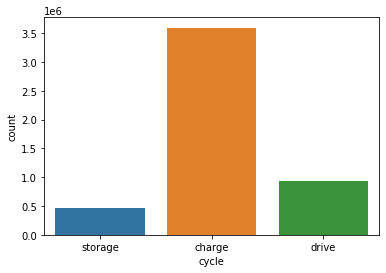

In [0]:
sns.countplot(filtered_data['cycle'])

In [0]:
bat_storage_data = filtered_data[bat_data['cycle'] == 'storage']
bat_charge_data = filtered_data[bat_data['cycle'] == 'charge']
bat_drive_data = filtered_data[bat_data['cycle'] == 'drive']
print("storage data dimensions are ", bat_storage_data.shape)
print("charge data dimensions are ", bat_charge_data.shape)
print("drive data dimensions are ", bat_drive_data.shape)

storage data dimensions are  (467495, 25)
charge data dimensions are  (3595456, 25)
drive data dimensions are  (937049, 25)


#### Encoding the data to apply Association rule Mining

In [0]:
encoded_storage = pd.get_dummies(bat_storage_data)
encoded_charge = pd.get_dummies(bat_charge_data)
encoded_drive = pd.get_dummies(bat_drive_data)

In [4]:
encoded_storage.head()

,fast_charge,odometer_High,odometer_Low,odometer_Medium,odometer_Very_High,ambient_temp_High,ambient_temp_Low,ambient_temp_Medium,ambient_temp_Very_High,vehicle_speed_Low,balancing_trigger_cell_High,balancing_trigger_cell_Low,balancing_trigger_cell_Medium,balancing_trigger_cell_Very_High,balancing_status_initialValue,balancing_status_noBalancing,balancing_status_passiveBalancing,min_voltage_High,min_voltage_Low,min_voltage_Medium,min_voltage_Very_High,min_temp_High,min_temp_Low,min_temp_Medium,min_temp_Very_High,traction_current_High,traction_current_Low,traction_current_Medium,traction_current_Very_High,max_voltage_High,max_voltage_Low,max_voltage_Medium,max_voltage_Very_High,imbalance_High,imbalance_Low,imbalance_Medium,imbalance_Very_High,traction_voltage_High,traction_voltage_Low,traction_voltage_Medium,...,min_temp_cell_Low,min_temp_cell_Medium,min_voltage_cell_High,min_voltage_cell_Low,min_voltage_cell_Medium,min_voltage_cell_Very_High,max_voltage_cell_High,max_voltage_cell_Low,max_voltage_cell_Medium,max_voltage_cell_Very_High,max_temp_High,max_temp_Low,max_temp_Medium,max_temp_Very_High,max_temp_cell_Low,max_temp_cell_Medium,emodule_temp_High,emodule_temp_Low,emodule_temp_Medium,emodule_temp_Very_High,thermal_manager_mode_activeCooling,thermal_manager_mode_activeHeating,thermal_manager_mode_idle,thermal_manager_mode_initialValue,thermal_manager_mode_passingCooling,thermal_manager_mode_thermalBalancing,outlet_coolant_temp_High,outlet_coolant_temp_Low,outlet_coolant_temp_Medium,outlet_coolant_temp_Very_High,soh_Low,soh_Medium,fast_charge_count_Low,cycle_storage,num_cycle_High,num_cycle_Low,num_cycle_Medium,num_cycle_Very_High,trip_distance_Low,trip_distance_Medium
0,False,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,0,0,1,0
1,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0
2,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0
3,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0
4,False,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0


### Applying Association Rule Mining

In [0]:
from mlxtend.frequent_patterns import apriori, association_rules

In [0]:
#association_rules = apriori(filtered_data, min_support=0.005)
#association_results = list(association_rules)


arm = apriori(encoded_data,min_support = 0.6, use_colnames = True) 

assoc_rules = association_rules(arm, metric ="confidence", min_threshold = 0.8) 
assoc_rules = assoc_rules.sort_values(['confidence', 'lift']) 

In [0]:
arm_storage = apriori(encoded_storage, min_support = 0.6, use_colnames = True) 

assoc_rules_storage = association_rules(arm_storage, metric ="confidence", min_threshold = 0.8) 
assoc_rules_storage = assoc_rules_storage.sort_values(['confidence', 'lift'])

In [0]:
arm_charge = apriori(encoded_charge, min_support = 0.6, use_colnames = True) 

assoc_rules_charge = association_rules(arm_charge, metric ="confidence", min_threshold = 0.8) 
assoc_rules_charge = assoc_rules_charge.sort_values(['confidence', 'lift'])

In [0]:
arm_drive = apriori(encoded_drive, min_support = 0.6, use_colnames = True) 

assoc_rules_drive = association_rules(arm_drive, metric ="confidence", min_threshold = 0.8) 
assoc_rules_drive = assoc_rules_drive.sort_values(['confidence', 'lift'])

In [0]:
#assoc_rules
assoc_rules["antecedent_len"] = assoc_rules["antecedents"].apply(lambda x: len(x))
assoc_rules[ (assoc_rules['antecedent_len'] >= 3) &
       (assoc_rules['confidence'] > 0.75)  ]

There was no rule with State of Health Low or High in the consequents but there were some rules with soh_Low in the antecedents.

In [25]:
assoc_rules_charge[(assoc_rules_charge['confidence'] > 0.75) & (assoc_rules_charge['antecedents'] == {'soh_Low'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
21,(soh_Low),(trip_distance_Low),0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
63,(soh_Low),"(trip_distance_Low, vehicle_speed_Low)",0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
114,(soh_Low),"(fast_charge_count_Low, trip_distance_Low)",0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
117,(soh_Low),"(cycle_charge, trip_distance_Low)",0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
200,(soh_Low),"(fast_charge_count_Low, trip_distance_Low, veh...",0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
207,(soh_Low),"(cycle_charge, trip_distance_Low, vehicle_spee...",0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
249,(soh_Low),"(fast_charge_count_Low, cycle_charge, trip_dis...",0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
309,(soh_Low),"(fast_charge_count_Low, cycle_charge, trip_dis...",0.785188,0.990161,0.777293,0.989944,0.999781,-0.00017,0.978408
3,(soh_Low),(vehicle_speed_Low),0.785188,1.000000,0.785188,1.000000,1.000000,0.00000,inf
19,(soh_Low),(fast_charge_count_Low),0.785188,1.000000,0.785188,1.000000,1.000000,0.00000,inf


In [21]:
assoc_rules_drive[(assoc_rules_drive['confidence'] > 0.75) & (assoc_rules_drive['antecedents'] == {'soh_Low'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
19,(soh_Low),(traction_current_Very_High),0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
61,(soh_Low),"(traction_current_Very_High, vehicle_speed_Low)",0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
159,(soh_Low),"(fast_charge_count_Low, traction_current_Very_...",0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
162,(soh_Low),"(traction_current_Very_High, cycle_drive)",0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
309,(soh_Low),"(fast_charge_count_Low, traction_current_Very_...",0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
316,(soh_Low),"(traction_current_Very_High, vehicle_speed_Low...",0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
485,(soh_Low),"(fast_charge_count_Low, traction_current_Very_...",0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
702,(soh_Low),"(fast_charge_count_Low, traction_current_Very_...",0.79423,0.801761,0.636289,0.801140,0.999226,-0.000493,0.996879
27,(soh_Low),(thermal_manager_mode_idle),0.79423,0.975297,0.774022,0.974558,0.999242,-0.000587,0.970944
86,(soh_Low),"(thermal_manager_mode_idle, vehicle_speed_Low)",0.79423,0.975297,0.774022,0.974558,0.999242,-0.000587,0.970944


In [22]:
assoc_rules_storage[(assoc_rules_storage['confidence'] > 0.75) & (assoc_rules_storage['antecedents'] == {'soh_Low'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
785,(soh_Low),"(thermal_manager_mode_idle, traction_current_V...",0.76317,0.853275,0.644013,0.843866,0.988973,-0.007181,0.939738
1217,(soh_Low),"(trip_distance_Low, thermal_manager_mode_idle,...",0.76317,0.853275,0.644013,0.843866,0.988973,-0.007181,0.939738
1697,(soh_Low),"(fast_charge_count_Low, thermal_manager_mode_i...",0.76317,0.853275,0.644013,0.843866,0.988973,-0.007181,0.939738
1712,(soh_Low),"(thermal_manager_mode_idle, traction_current_V...",0.76317,0.853275,0.644013,0.843866,0.988973,-0.007181,0.939738
2128,(soh_Low),"(thermal_manager_mode_idle, traction_current_V...",0.76317,0.853275,0.644013,0.843866,0.988973,-0.007181,0.939738
...,...,...,...,...,...,...,...,...,...
40,(soh_Low),(cycle_storage),0.76317,1.000000,0.763170,1.000000,1.000000,0.000000,inf
128,(soh_Low),"(fast_charge_count_Low, vehicle_speed_Low)",0.76317,1.000000,0.763170,1.000000,1.000000,0.000000,inf
131,(soh_Low),"(vehicle_speed_Low, cycle_storage)",0.76317,1.000000,0.763170,1.000000,1.000000,0.000000,inf
290,(soh_Low),"(fast_charge_count_Low, cycle_storage)",0.76317,1.000000,0.763170,1.000000,1.000000,0.000000,inf


### ARM on the complete Encoded Dataset

In [0]:
#assoc_rules["antecedent_len"] = assoc_rules["antecedents"].apply(lambda x: len(x))
assoc_rules[(assoc_rules['confidence'] > 0.75) & (assoc_rules['antecedents'] == {'soh_Low'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
13,(soh_Low),(trip_distance_Low),0.784824,0.903743,0.708462,0.902702,0.998848,-0.000817,0.9893,1
35,(soh_Low),"(vehicle_speed_Low, trip_distance_Low)",0.784824,0.903743,0.708462,0.902702,0.998848,-0.000817,0.9893,1
56,(soh_Low),"(trip_distance_Low, fast_charge_count_Low)",0.784824,0.903743,0.708462,0.902702,0.998848,-0.000817,0.9893,1
80,(soh_Low),"(vehicle_speed_Low, trip_distance_Low, fast_ch...",0.784824,0.903743,0.708462,0.902702,0.998848,-0.000817,0.9893,1
2,(soh_Low),(vehicle_speed_Low),0.784824,1.000000,0.784824,1.000000,1.000000,0.000000,inf,1
12,(soh_Low),(fast_charge_count_Low),0.784824,1.000000,0.784824,1.000000,1.000000,0.000000,inf,1
32,(soh_Low),"(vehicle_speed_Low, fast_charge_count_Low)",0.784824,1.000000,0.784824,1.000000,1.000000,0.000000,inf,1


### Further subsets of each of the cycle - W.R.T State of Health

In [0]:
encoded_storage_sh = encoded_storage[encoded_storage['soh_Medium'] == 1]
encoded_storage_sl = encoded_storage[encoded_storage['soh_Low'] == 1]

In [0]:
arm_storage_high = apriori(encoded_storage_sh, min_support = 0.6, use_colnames = True) 

assoc_rules_storage_high = association_rules(arm_storage_high, metric ="confidence", min_threshold = 0.8) 
assoc_rules_storage_high = assoc_rules_storage_high.sort_values(['confidence', 'lift'])

arm_storage_low = apriori(encoded_storage_sl, min_support = 0.6, use_colnames = True) 

assoc_rules_storage_low = association_rules(arm_storage_low, metric ="confidence", min_threshold = 0.8) 
assoc_rules_storage_low = assoc_rules_storage_low.sort_values(['confidence', 'lift'])

In [12]:
assoc_rules_storage_high[(assoc_rules_storage_high['confidence'] > 0.75) & (assoc_rules_storage_high['consequents'] == {'soh_Medium'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
8,(vehicle_speed_Low),(soh_Medium),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
20,(balancing_status_noBalancing),(soh_Medium),0.951155,1.0,0.951155,1.0,1.0,0.0,inf
32,(traction_current_Very_High),(soh_Medium),0.992088,1.0,0.992088,1.0,1.0,0.0,inf
40,(max_temp_cell_Low),(soh_Medium),0.693498,1.0,0.693498,1.0,1.0,0.0,inf
45,(thermal_manager_mode_idle),(soh_Medium),0.908740,1.0,0.908740,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
9747,"(thermal_manager_mode_idle, traction_current_V...",(soh_Medium),0.614558,1.0,0.614558,1.0,1.0,0.0,inf
9809,"(thermal_manager_mode_idle, traction_current_V...",(soh_Medium),0.606257,1.0,0.606257,1.0,1.0,0.0,inf
9937,"(traction_current_Very_High, balancing_status_...",(soh_Medium),0.643659,1.0,0.643659,1.0,1.0,0.0,inf
10064,"(thermal_manager_mode_idle, traction_current_V...",(soh_Medium),0.836385,1.0,0.836385,1.0,1.0,0.0,inf


In [14]:
assoc_rules_storage_low[(assoc_rules_storage_low['confidence'] > 0.75) & (assoc_rules_storage_low['consequents'] == {'soh_Low'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,(vehicle_speed_Low),(soh_Low),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
16,(balancing_status_noBalancing),(soh_Low),0.714629,1.0,0.714629,1.0,1.0,0.0,inf
23,(traction_current_Very_High),(soh_Low),0.989279,1.0,0.989279,1.0,1.0,0.0,inf
32,(max_temp_cell_Low),(soh_Low),0.718096,1.0,0.718096,1.0,1.0,0.0,inf
36,(thermal_manager_mode_idle),(soh_Low),0.874460,1.0,0.874460,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
4672,"(traction_current_Very_High, max_temp_cell_Low...",(soh_Low),0.688408,1.0,0.688408,1.0,1.0,0.0,inf
4735,"(thermal_manager_mode_idle, traction_current_V...",(soh_Low),0.843866,1.0,0.843866,1.0,1.0,0.0,inf
4861,"(thermal_manager_mode_idle, max_temp_cell_Low,...",(soh_Low),0.617642,1.0,0.617642,1.0,1.0,0.0,inf
4923,"(thermal_manager_mode_idle, traction_current_V...",(soh_Low),0.615220,1.0,0.615220,1.0,1.0,0.0,inf


In [0]:
encoded_drive_sh = encoded_drive[encoded_drive['soh_Medium'] == 1]
encoded_drive_sl = encoded_drive[encoded_drive['soh_Low'] == 1]

encoded_charge_sh = encoded_charge[encoded_charge['soh_Medium'] == 1]
encoded_charge_sl = encoded_charge[encoded_charge['soh_Low'] == 1]

In [0]:
arm_drive_high = apriori(encoded_drive_sh, min_support = 0.6, use_colnames = True) 

assoc_rules_drive_high = association_rules(arm_drive_high, metric ="confidence", min_threshold = 0.8) 
assoc_rules_drive_high = assoc_rules_drive_high.sort_values(['confidence', 'lift'])

arm_drive_low = apriori(encoded_drive_sl, min_support = 0.6, use_colnames = True) 

assoc_rules_drive_low = association_rules(arm_drive_low, metric ="confidence", min_threshold = 0.8) 
assoc_rules_drive_low = assoc_rules_drive_low.sort_values(['confidence', 'lift'])

arm_charge_high = apriori(encoded_charge_sh, min_support = 0.6, use_colnames = True) 

assoc_rules_charge_high = association_rules(arm_charge_high, metric ="confidence", min_threshold = 0.8) 
assoc_rules_charge_high = assoc_rules_charge_high.sort_values(['confidence', 'lift'])

arm_charge_low = apriori(encoded_charge_sl, min_support = 0.6, use_colnames = True) 

assoc_rules_charge_low = association_rules(arm_charge_low, metric ="confidence", min_threshold = 0.8) 
assoc_rules_charge_low = assoc_rules_charge_low.sort_values(['confidence', 'lift'])

In [17]:
assoc_rules_drive_high[(assoc_rules_drive_high['confidence'] > 0.75) & (assoc_rules_drive_high['consequents'] == {'soh_Medium'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9,(vehicle_speed_Low),(soh_Medium),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
20,(balancing_status_noBalancing),(soh_Medium),0.979094,1.0,0.979094,1.0,1.0,0.0,inf
31,(traction_current_Very_High),(soh_Medium),0.804156,1.0,0.804156,1.0,1.0,0.0,inf
39,(max_temp_cell_Low),(soh_Medium),0.801558,1.0,0.801558,1.0,1.0,0.0,inf
45,(thermal_manager_mode_idle),(soh_Medium),0.978150,1.0,0.978150,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
3557,"(thermal_manager_mode_idle, traction_current_V...",(soh_Medium),0.781803,1.0,0.781803,1.0,1.0,0.0,inf
3636,"(thermal_manager_mode_idle, balancing_status_n...",(soh_Medium),0.769035,1.0,0.769035,1.0,1.0,0.0,inf
3715,"(thermal_manager_mode_idle, traction_current_V...",(soh_Medium),0.640073,1.0,0.640073,1.0,1.0,0.0,inf
3778,"(thermal_manager_mode_idle, traction_current_V...",(soh_Medium),0.628031,1.0,0.628031,1.0,1.0,0.0,inf


In [18]:
assoc_rules_drive_low[(assoc_rules_drive_low['confidence'] > 0.75) & (assoc_rules_drive_low['consequents'] == {'soh_Low'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,(vehicle_speed_Low),(soh_Low),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
13,(balancing_status_noBalancing),(soh_Low),0.717452,1.0,0.717452,1.0,1.0,0.0,inf
19,(traction_current_Very_High),(soh_Low),0.801140,1.0,0.801140,1.0,1.0,0.0,inf
26,(max_temp_cell_Low),(soh_Low),0.797344,1.0,0.797344,1.0,1.0,0.0,inf
29,(thermal_manager_mode_idle),(soh_Low),0.974558,1.0,0.974558,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
1156,"(traction_current_Very_High, max_temp_cell_Low...",(soh_Low),0.638889,1.0,0.638889,1.0,1.0,0.0,inf
1187,"(thermal_manager_mode_idle, traction_current_V...",(soh_Low),0.792890,1.0,0.792890,1.0,1.0,0.0,inf
1234,"(thermal_manager_mode_idle, max_temp_cell_Low,...",(soh_Low),0.776926,1.0,0.776926,1.0,1.0,0.0,inf
1264,"(thermal_manager_mode_idle, traction_current_V...",(soh_Low),0.632210,1.0,0.632210,1.0,1.0,0.0,inf


In [19]:
assoc_rules_charge_high[(assoc_rules_charge_high['confidence'] > 0.75) & (assoc_rules_charge_high['consequents'] == {'soh_Medium'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(vehicle_speed_Low),(soh_Medium),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
14,(balancing_status_noBalancing),(soh_Medium),0.976924,1.0,0.976924,1.0,1.0,0.0,inf
22,(max_temp_cell_Low),(soh_Medium),0.768930,1.0,0.768930,1.0,1.0,0.0,inf
26,(thermal_manager_mode_activeHeating),(soh_Medium),0.645259,1.0,0.645259,1.0,1.0,0.0,inf
30,(fast_charge_count_Low),(soh_Medium),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
1717,"(thermal_manager_mode_activeHeating, vehicle_s...",(soh_Medium),0.639724,1.0,0.639724,1.0,1.0,0.0,inf
1747,"(balancing_status_noBalancing, max_temp_cell_L...",(soh_Medium),0.744603,1.0,0.744603,1.0,1.0,0.0,inf
1778,"(thermal_manager_mode_activeHeating, balancing...",(soh_Medium),0.623003,1.0,0.623003,1.0,1.0,0.0,inf
1809,"(balancing_status_noBalancing, max_temp_cell_L...",(soh_Medium),0.744603,1.0,0.744603,1.0,1.0,0.0,inf


In [20]:
assoc_rules_charge_low[(assoc_rules_charge_low['confidence'] > 0.75) & (assoc_rules_charge_low['consequents'] == {'soh_Low'})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(vehicle_speed_Low),(soh_Low),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
11,(balancing_status_noBalancing),(soh_Low),0.614605,1.0,0.614605,1.0,1.0,0.0,inf
15,(max_temp_cell_Low),(soh_Low),0.760799,1.0,0.760799,1.0,1.0,0.0,inf
19,(thermal_manager_mode_activeHeating),(soh_Low),0.628408,1.0,0.628408,1.0,1.0,0.0,inf
23,(fast_charge_count_Low),(soh_Low),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
693,"(fast_charge_count_Low, trip_distance_Low, cyc...",(soh_Low),0.752939,1.0,0.752939,1.0,1.0,0.0,inf
708,"(fast_charge_count_Low, thermal_manager_mode_a...",(soh_Low),0.622441,1.0,0.622441,1.0,1.0,0.0,inf
724,"(balancing_status_noBalancing, vehicle_speed_L...",(soh_Low),0.607933,1.0,0.607933,1.0,1.0,0.0,inf
755,"(max_temp_cell_Low, vehicle_speed_Low, trip_di...",(soh_Low),0.752939,1.0,0.752939,1.0,1.0,0.0,inf


In [0]:
del bat_data, bat_drive_data, bat_storage_data
bat_data.head()

NameError: ignored

In [0]:
import dill
dill.dump_session('phase-II-ml-copy.db')